# 

#  Vanilla logistic regression with almost no extras.

In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 3

env: CUDA_VISIBLE_DEVICES=3


Import necessary tools.

In [16]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd

from nbtools.core import get_notebook_name

from batchflow import Pipeline, Notifier, B, V, I, M, C, plot
from batchflow.models.torch import TorchModel

from loader import ImagesDataset
from plotter import plot_notifier_curve
from evaluator import MetricsEvaluator

Get notebook name and use it as an experiment name.

In [3]:
NAME = get_notebook_name()
NAME

'01_LOGISTIC'

Define seed for reproducibility.

In [4]:
SEED = 11
rng = np.random.default_rng(SEED)

Load data, encode labels, normalize images, resize them to same square shape.

Normalization stats are calculated over train subset to avoid data leak.

Split the data on train and test subsets with fixed seed.

In [19]:
DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=SEED)
train_uniques, train_counts = np.unique(dataset.labels[dataset.train.indices], return_counts=True)
train_shares = train_counts / train_counts.sum()

Define a logistic regression config. What is basically says is that our model is a single fully connected layer (`f` maps to torch.Linear) followed by softmax for `n_classes`. The criterion to optimize is CrossEntropy — a golden standard in common classification tasks. Adam with default learning rate (`1e-3`) is used to perform loss minimazation. As for decay, it reduced learning rate every `frequency` train iterations.

In [6]:
MODEL_CONFIG = {
    # Model architecture:
    'head' : {
        'layout': 'f',
        'classes': n_classes
    },

    # Model training details:
    'loss': 'ce',
    'optimizer': 'Adam',
    'decay': {'name': 'exp', 'frequency': 1500},
    'output': {'predicted': ['proba', 'labels']},
    'device': 'cuda:0'
}

Define train and test pipeline and supplementary functions. They are pretty self-documenting, so I'll describe the overall idea of training process:

1. Load data and flatten it into a vector (bye-bye spatial info).
2. Initialize variables to store loss values, evaluation metrics and also initialize model with config from above.
3. Train model on batch inputs and targets.
4. Call evaluation function, that triggers the process of prediction on **test subset** of data and metrics calculation every `TEST_FREQUENCY` iterations.

Repeat everything for `N_EPOCHS`.

There is also the second pipeline, the test one, which is used inside evaluation function, that loads data in the manner as the training one, import trained model, performs inference and saves predictions for their evaluation.

In [7]:
def flatten(batch, src, dst):
    data = getattr(batch, src)
    data = data.reshape(data.shape[0], -1)
    setattr(batch, dst, data)    

def evaluate_metrics(iteration, frequency, template, model, metrics):
    if (iteration - 1) % frequency == 0:
        
        test_pipeline = test_template << dataset.test << {'model': model}
        test_pipeline.run(batch_size=dataset.test.size, n_epochs=1, drop_last=False)
        
        metrics_values = []
        for metric_name, metric_config in metrics.items():
            metric_value = test_pipeline.v('metrics').evaluate(metric_name, **metric_config)
            metrics_values.append([metric_value])

        return metrics_values
    return [[],[],[]]


train_template = (
    Pipeline()
    # prepare data
    .flatten(B(), src='images', dst='inputs')
    
    # initialize loss and metrics containers
    .init_variable(name='loss_history', default=[])
    .init_variable(name='accuracy', default=[])
    .init_variable(name='precision', default=[[np.nan] * n_classes])
    .init_variable(name='recall', default=[[np.nan] * n_classes])
    
    # initialize model to train
    .init_model(name='model', model_class=TorchModel, mode='dynamic', config=MODEL_CONFIG)
    
    # launch train itself
    .train_model(name='model', inputs=B('inputs'), targets=B('labels'),
                 outputs='loss', save_to=V('loss_history', mode='a'))
    
    # evaluate model
    .call(evaluate_metrics, iteration=I(), template=C('evaluate/template'), model=M('model'),
          frequency=C('evaluate/frequency'), metrics=C('evaluate/metrics'),
          save_to=[V('accuracy', mode='e'), V('precision', mode='e'), V('recall', mode='e')])
)

test_template = (
    Pipeline()
    # prepare data
    .flatten(B(), src='images', dst='inputs')

    # initialize prediction and metrics containers
    .init_variables('proba', 'predictions', 'metrics')

    # import trained model
    .import_model('model', C('model'))

    # make predictions
    .predict_model(name='model', inputs=B('inputs'),
                   outputs=['predicted_proba', 'predictions'],
                   save_to=[V('proba'), V('predictions')])

    # accumulate predictions in confusion matrix
    .gather_metrics('classification', targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', num_classes=n_classes,
                    axis=1, save_to=V('metrics', mode='update'))
)

TEST_FREQUENCY = 250

train_config = {
    'evaluate' : {
        'template': test_template,
        'frequency': TEST_FREQUENCY,
        'metrics': {
            'accuracy': {},
            'precision': {'multiclass': None},
            'recall': {'multiclass': None},
        }
    }
}

train_pipeline = train_template << dataset.train << train_config

Define parameters for notifier that monitors computational resources and metrics values.

Run pipeline defined above for `N_EPOCHS` epochs. Why 200? — After that the evaluation metrics tend to decrease, which likely is a sign of model overfitting.

According to gpu memory monitor the batch size can be easily doubled, but here we just don't care, it's a baseline that trains in a minute.

Kinda noisy metrics values indicate that model prediction is unstable. If one wishes to obtain consistent results across the re-runs, he or she better average a couple of trained models. We won't do it here.

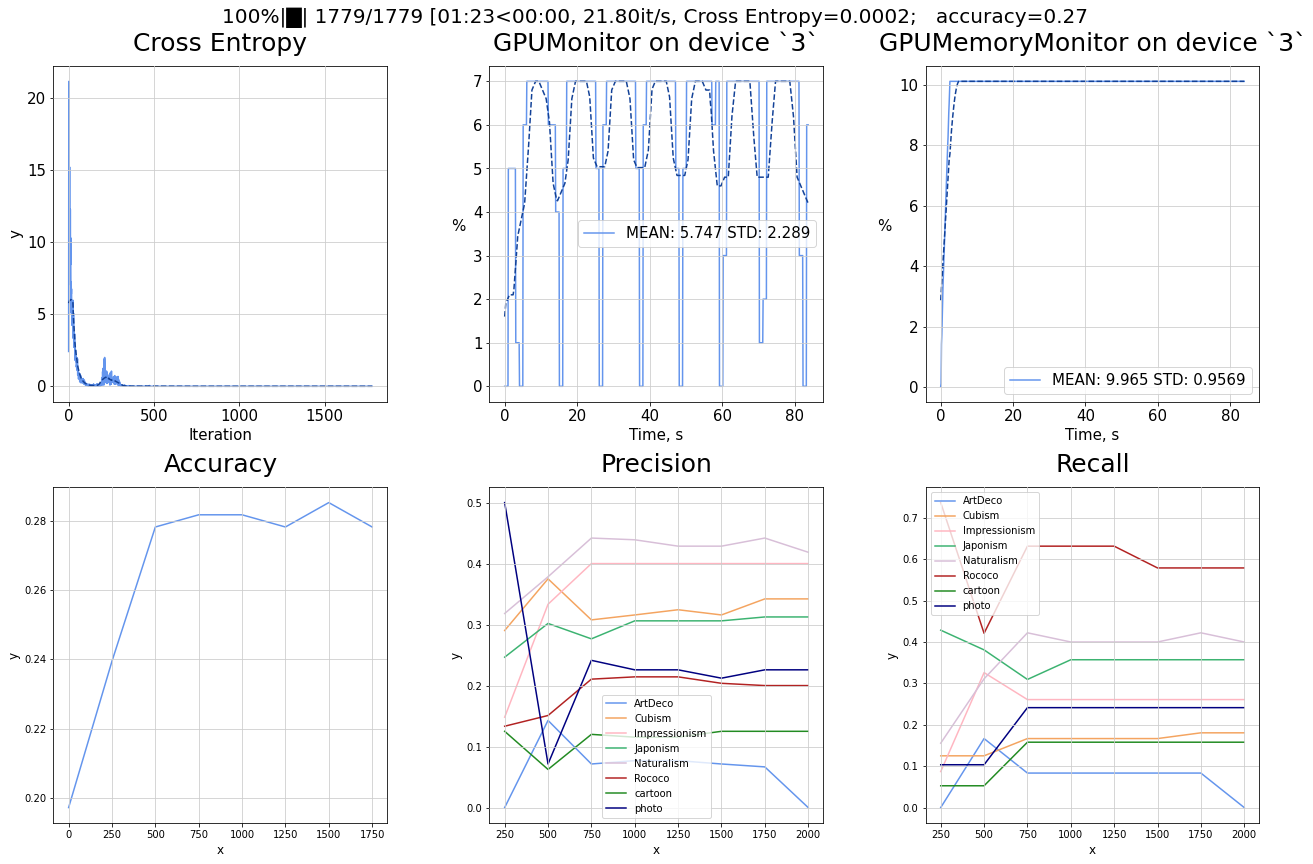

In [8]:
notifier = Notifier(**{
    'frequency': TEST_FREQUENCY,
    'graphs': [
        {
            'source': 'loss_history',
            'name': 'Cross Entropy',
        },
        'gpu',
        'gpu_memory',
        {
            'source': 'accuracy',
            'plot_function': plot_notifier_curve,
            'plot_config': {
                'title': 'Accuracy',
                'frequency': TEST_FREQUENCY,
            }
        },
        {
            'source': train_pipeline.v('precision'),
            'plot_function': plot_notifier_curve,
            'plot_config': {
                'label': list(dataset.label_encoder.classes_),
                'legend_size': 10,
                'title': 'Precision',
                'frequency': TEST_FREQUENCY,
            },
        },
        {
            'source': train_pipeline.v('recall'),
            'plot_function': plot_notifier_curve,
            'plot_config': {
                'label': list(dataset.label_encoder.classes_),
                'legend_size': 10,
                'title': 'Recall',
                'frequency': TEST_FREQUENCY,
            },
        }
    ],
    'plot_config': {
        'ncols': 3, 'nrows': 2
    }
})

BATCH_SIZE = 128
N_EPOCHS = 200

_ = train_pipeline.run(batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, shuffle=True, notifier=notifier)

We've trained, now its inference time!

In [10]:
test_pipeline = test_template << dataset.test << {'model': train_pipeline.model}
test_pipeline.run(batch_size=dataset.test.size, n_epochs=1, drop_last=False, bar='t')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.71it/s]


Let's look at metrics values.

The first thing one probably notices, is that the class#0 is totally misclassified. Poor ArtDeco, no one knows how it looks like, not even allmighty logistic regression. Even thought the previous statement on ArtDeco ambiguity is kinda matches with opinions of some art critics, the real reason behind zero metrics values is most definitely the class underrepresentation in train dataset. If hypithetical "business" somehow desides that error on this specific class are critical, than sampling on train or loss weighting might help. As for now, since it's a pretty vanilla regression baseline, we'll leave it 'as is'.

The second class that is not feeling so good is the cartoon one. Also, underrepresented.

As for other metrics, they are not great, but also not terrible and actually better than our naive solution with random guesses.

Confusion matrix now shows some kind of relevancy to actual target labels (main diagonal dominates).

Ok, that was a simple baseline. Let's move on.

,shares,precision,recall
ArtDeco,4.7,0.0,0.0
Cubism,25.7,34.2,18.1
Impressionism,17.0,40.0,26.1
Japonism,14.1,31.2,35.7
Naturalism,15.2,41.9,40.0
Rococo,8.6,20.0,57.9
cartoon,4.9,12.5,15.8
photo,9.7,22.6,24.1


,accuracy,f1_score
altogether,27.8,26.2


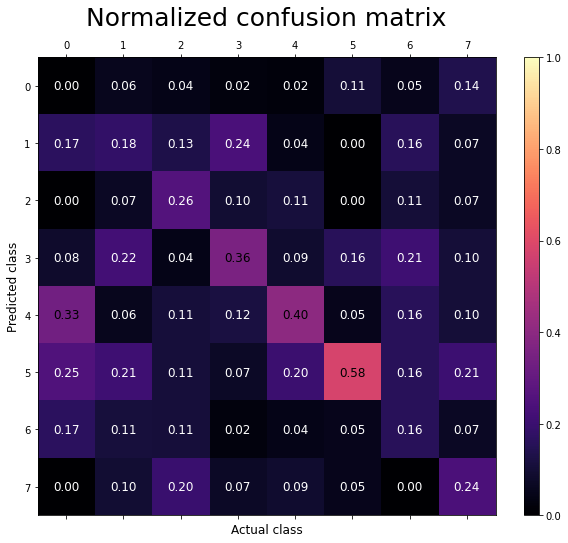

In [22]:
METRICS_PATH = f'../metrics/{NAME}.json'

evaluator = MetricsEvaluator(metrics=test_pipeline.v('metrics'), classes=dataset.classes, shares=train_shares)
metrics_dict = evaluator.evaluate_classification_metrics(show=True, savepath=METRICS_PATH)

Metrics saved for future comparison.